## 4.1 Imports

In [2]:
import pandas as pd
from sklearn import tree
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import NearMiss
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,plot_confusion_matrix,f1_score,accuracy_score as acc
from sklearn.model_selection import ParameterGrid,RandomizedSearchCV,PredefinedSplit,GridSearchCV,learning_curve
from imblearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample

plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams['font.size'] = 14
         
            

## 4.2 Load The Training And Test Data


In [3]:
train = pd.read_csv('../data/training_step3.csv')
val = pd.read_csv('../data/validation_step3.csv')
test = pd.read_csv('../data/test_step3.csv')

In [4]:
X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]

X_val = val.iloc[:,:-1]
y_val = val.iloc[:,-1]

X_test = test.iloc[:,:-1]
y_test= test.iloc[:,-1]

## 4.3 Decision Tree Model

### 4.3.1 Basic Decision Tree Model


In [158]:
#fit a decision tree model
decision_tree = tree.DecisionTreeClassifier(max_depth = 10,random_state= 42)
decision_tree.fit(X_train,y_train)
pred_y_train = decision_tree.predict(X_train)
print(classification_report(y_train,pred_y_train))

              precision    recall  f1-score   support

           1       0.80      0.78      0.79    135578
           2       0.81      0.86      0.84    181312
           3       0.79      0.82      0.81     22882
           4       0.83      0.67      0.74      1759
           5       0.77      0.35      0.48      6075
           6       0.67      0.45      0.54     11115
           7       0.88      0.76      0.82     13126

    accuracy                           0.81    371847
   macro avg       0.79      0.67      0.72    371847
weighted avg       0.80      0.81      0.80    371847



In [159]:
pred_y_val = decision_tree.predict(X_val)
print(classification_report(y_val,pred_y_val))

              precision    recall  f1-score   support

           1       0.79      0.77      0.78     33894
           2       0.80      0.86      0.83     45328
           3       0.78      0.82      0.80      5721
           4       0.81      0.65      0.72       439
           5       0.76      0.33      0.46      1519
           6       0.65      0.43      0.52      2779
           7       0.88      0.76      0.81      3282

    accuracy                           0.80     92962
   macro avg       0.78      0.66      0.70     92962
weighted avg       0.80      0.80      0.79     92962



The basic decision tree with max depth 10 is underfitting. The recall scores on cover type 5 and 6 are only 0.33 and 0.43,so the decision tree cannot effectively identify them from others. And we can see the socres bewtween training set and test set are very close due to high bias.

But compared to the recall socres of 0.04 and 0.28 on cover type 5 and 6 by the baseline model (logistic regression), the decision tree has improved a lot. Meanwhile, the accuracy, weighted average precision, recall, f1-score are 8% higher respectivley. The macro average precision, recall and f1-score are 15%, 14% and 16% higher.


### 4.3.2 Hyperparameter Tuning For The Decision Tree Model

In [250]:
params = {'max_depth': np.arange(10,60,3)}


decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy',random_state= 42)
best_score = 0

f1_score_train = []
f1_score_val = []

acc_score_train = []
acc_score_trainval = []

# perform brute-force grid search to try out all parameters
for g in ParameterGrid(params):
    decision_tree.set_params(**g)
    decision_tree.fit(X_train, y_train)  
    pred_y_train = decision_tree.predict(X_train)
    pred_y_val = decision_tree.predict(X_val)
    
    #macro f1 scores
    f1_score_train.append(f1_score(y_train, pred_y_train,average = 'macro'))
    f1_score_val.append(f1_score(y_val, pred_y_val,average = 'macro'))
    
    #accuracy scores
    acc_score_train.append(acc(y_train, pred_y_train))
    acc_score_trainval.append(acc(y_val, pred_y_val))
     

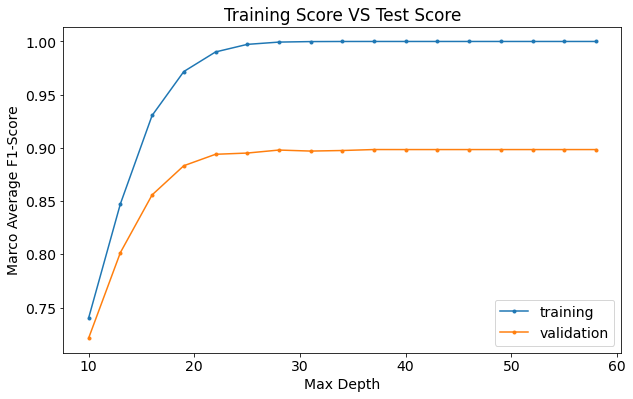

In [378]:
#plot the f1 socres 
plt.plot(np.arange(10,60,3),f1_score_train,marker='.',label = 'training')
plt.plot(np.arange(10,60,3),f1_score_val,marker='.',label = 'validation')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Marco Average F1-Score')
plt.title('Training Score VS Test Score')
plt.show()

The model at max depth 19 seems to perform the best. The gap between training score and validation score becomes bigger and slowly stablize after 19.

In [342]:
best_decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy',max_depth = 19,random_state= 42)
best_decision_tree.fit(X_train,y_train)
pred_y_train = best_decision_tree.predict(X_train)
pred_y_val = best_decision_tree.predict(X_val)

In [343]:
print(classification_report(y_train,pred_y_train))

              precision    recall  f1-score   support

           1       0.95      0.93      0.94    135578
           2       0.95      0.97      0.96    181312
           3       0.99      0.99      0.99     22882
           4       1.00      0.97      0.99      1759
           5       0.97      0.94      0.95      6075
           6       0.99      0.98      0.98     11115
           7       0.99      0.98      0.99     13126

    accuracy                           0.96    371847
   macro avg       0.98      0.97      0.97    371847
weighted avg       0.96      0.96      0.96    371847



In [344]:
print(classification_report(y_val,pred_y_val))

              precision    recall  f1-score   support

           1       0.91      0.89      0.90     33894
           2       0.91      0.93      0.92     45328
           3       0.92      0.93      0.92      5721
           4       0.85      0.82      0.83       439
           5       0.81      0.79      0.80      1519
           6       0.88      0.86      0.87      2779
           7       0.95      0.93      0.94      3282

    accuracy                           0.91     92962
   macro avg       0.89      0.88      0.88     92962
weighted avg       0.91      0.91      0.91     92962



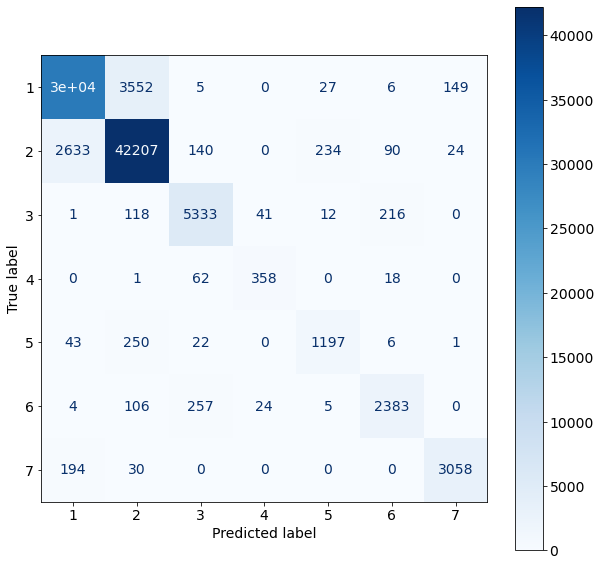

In [496]:
fig,ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(best_decision_tree,X_val,y_val,cmap=plt.cm.Blues,ax = ax)
plt.show()

The decision tree with max depth 19 has a great improvment comprehensively on both of the training set of validation set. Compared to the one with max depth 10, the accuracy, macro average f1_score, and weighted average f1_score on the validation set have improved by 11%, 18% and 10%, respectively. In particular, the model has successfully learned more difference between the majorities and minorities. Far less samples belonging to class 4 and 5 are misclassified, given  recalls of these two classes rising by 46% and 43%.

## 4.4 Random Forest Model

### 4.3.1 Basic Random Forest Model

In [257]:
#fit a random forest model with default values
random_forest = RandomForestClassifier()
random_forest.fit(X_train,y_train)

pred_y_train = random_forest.predict(X_train)
pred_y_val = random_forest.predict(X_val)

In [258]:
print(classification_report(y_train,pred_y_train))


              precision    recall  f1-score   support

           1       1.00      1.00      1.00    135578
           2       1.00      1.00      1.00    181312
           3       1.00      1.00      1.00     22882
           4       1.00      1.00      1.00      1759
           5       1.00      1.00      1.00      6075
           6       1.00      1.00      1.00     11115
           7       1.00      1.00      1.00     13126

    accuracy                           1.00    371847
   macro avg       1.00      1.00      1.00    371847
weighted avg       1.00      1.00      1.00    371847



In [259]:
print(classification_report(y_val,pred_y_val))

              precision    recall  f1-score   support

           1       0.96      0.94      0.95     33894
           2       0.94      0.97      0.96     45328
           3       0.94      0.96      0.95      5721
           4       0.91      0.85      0.88       439
           5       0.91      0.75      0.82      1519
           6       0.92      0.89      0.91      2779
           7       0.97      0.94      0.96      3282

    accuracy                           0.95     92962
   macro avg       0.94      0.90      0.92     92962
weighted avg       0.95      0.95      0.95     92962



The random forest model seems overfitting, but it captures more variance over different forest cover types. It might be a good candidate with optimal paramters. 

### 4.4.2 Hyperparameter Tuning for The Random Forest Model

In [568]:
params = {'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 100,num = 6)],
          'max_depth' : [14,17,19,22,25]}
         

#append the training set and validation set in order to adapt for the RandomForestClassifier
#our validaiton set is predefined and we don't want RandomForestClassifier validate using our training set
X_train_val = X_train.append(X_val)
y_train_val = y_train.append(y_val)

#set the index of the predefined set to 0, so the RandomizedSearchCV will not train on the predefined validation set
predefined_folds = np.zeros(X_train_val.shape[0])
#set the index of the training set to -1
predefined_folds[:X_train.shape[0]] = -1
pfs = PredefinedSplit(test_fold = predefined_folds) 
  
    

random_forest = RandomForestClassifier(criterion = 'entropy',
                                       max_depth = 19,
                                       random_state = 42)
 
rs1 = GridSearchCV(estimator = random_forest,
                        param_grid = params,
                        scoring='f1_macro',
                        cv = pfs,
                        verbose= 10,
                        n_jobs= -1,
                        return_train_score= True)

rs1.fit(X_train_val,y_train_val)
rs1.best_params_


Fitting 1 folds for each of 30 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 25.6min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 27.6min finished


{'max_depth': 25, 'n_estimators': 100}

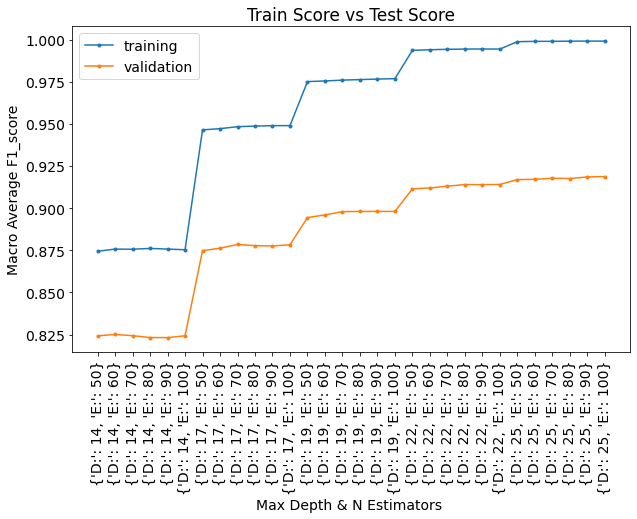

In [570]:
#plot the f1 socres 
params = rs1.cv_results_['params']
xticks = [dict(zip(['D:','E:'],dic.values())) for dic in params]

plt.plot(np.arange(0,30), rs1.cv_results_['mean_train_score'],marker='.', label = 'training')
plt.plot(np.arange(0,30),rs1.cv_results_['mean_test_score'],marker='.',label = 'validation')
plt.legend()
plt.xticks(np.arange(0,30),xticks,rotation = 90)
plt.xlabel('Max Depth & N Estimators ')
plt.ylabel('Macro Average F1_score')
plt.title('Train Score vs Test Score')
plt.show()

Although the GridSearchCV gives max_depth 25 and n_estimators 100 as the best parameters, the graph above presents a hihger variance for max depth 25. Meanwhile, the model tends to be bias for max depth 14 and adding more estimtors does not significantly affect the socres much,but we can see a subtle upward trend on the validation socre when holding the max depth constant. Such that, max depth 19 and n_estimators 70 would be a good choice.

In [571]:
random_forest1 = RandomForestClassifier(n_estimators= 70,
                                        max_depth= 19,
                                        criterion= 'entropy',
                                        random_state = 42,
                                        n_jobs = -1)

#random_forest1.set_params(**rs1.best_params_)
random_forest1.fit(X_train,y_train)
pred_y_train = random_forest1.predict(X_train)
pred_y_val = random_forest1.predict(X_val)

In [572]:
print(classification_report(y_train,pred_y_train))

              precision    recall  f1-score   support

           1       0.98      0.93      0.95    135578
           2       0.95      0.98      0.97    181312
           3       1.00      1.00      1.00     22882
           4       1.00      0.99      1.00      1759
           5       1.00      0.89      0.94      6075
           6       0.99      0.99      0.99     11115
           7       1.00      0.98      0.99     13126

    accuracy                           0.97    371847
   macro avg       0.99      0.97      0.98    371847
weighted avg       0.97      0.97      0.97    371847



In [573]:
print(classification_report(y_val,pred_y_val))


              precision    recall  f1-score   support

           1       0.94      0.89      0.91     33894
           2       0.91      0.96      0.93     45328
           3       0.93      0.95      0.94      5721
           4       0.91      0.87      0.89       439
           5       0.91      0.68      0.78      1519
           6       0.90      0.88      0.89      2779
           7       0.97      0.92      0.95      3282

    accuracy                           0.92     92962
   macro avg       0.92      0.88      0.90     92962
weighted avg       0.92      0.92      0.92     92962



The model is less likeley to be overfitting, but the recall of class 5 decreased by 7%.
Next, adjust the number of maximum features for spliting a node. 

In [589]:
#total number of features 
train.shape[1]

29

The default max_features is sqrt(n_features), which is 5 in our case. 

In [579]:
params = {'max_features': [4,5,6,7]}
         
random_forest = RandomForestClassifier(criterion = 'entropy',
                                       max_depth = 19,
                                       n_estimators = 70,
                                       random_state = 42)

rs2 = GridSearchCV(estimator = random_forest,
                        param_grid = params,
                        scoring='f1_macro',
                        cv = pfs,
                        verbose= 10,
                        n_jobs= -1,
                        return_train_score= True)

rs2.fit(X_train_val,y_train_val)
rs2.best_params_


Fitting 1 folds for each of 4 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  3.6min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  4.1min finished


{'max_features': 7}

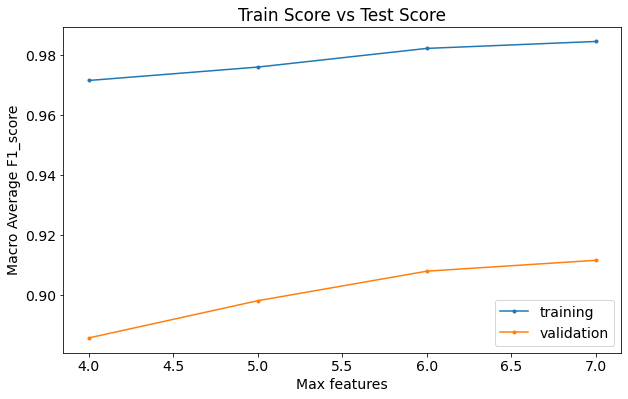

In [580]:
#plot the f1 socres 
plt.plot(params['max_features'], rs2.cv_results_['mean_train_score'],marker='.', label = 'training')
plt.plot(params['max_features'],rs2.cv_results_['mean_test_score'],marker='.',label = 'validation')
plt.legend()
plt.xlabel('Max features')
plt.ylabel('Macro Average F1_score')
plt.title('Train Score vs Test Score')
plt.show()

The gap of scores on training set and validation set converges rapidly till max features reaches 6.

In [597]:
random_forest2 = RandomForestClassifier(n_estimators= 70,
                                        max_depth= 19,
                                        criterion= 'entropy',
                                        random_state = 42,
                                        max_features = 6, 
                                        n_jobs = -1)

#random_forest1.set_params(**rs1.best_params_)
random_forest2.fit(X_train,y_train)
pred_y_train = random_forest2.predict(X_train)
pred_y_val = random_forest2.predict(X_val)

In [598]:
print(classification_report(y_train,pred_y_train))

              precision    recall  f1-score   support

           1       0.98      0.94      0.96    135578
           2       0.96      0.99      0.97    181312
           3       1.00      1.00      1.00     22882
           4       1.00      1.00      1.00      1759
           5       1.00      0.93      0.96      6075
           6       0.99      0.99      0.99     11115
           7       1.00      0.98      0.99     13126

    accuracy                           0.97    371847
   macro avg       0.99      0.98      0.98    371847
weighted avg       0.97      0.97      0.97    371847



In [599]:
print(classification_report(y_val,pred_y_val))


              precision    recall  f1-score   support

           1       0.95      0.90      0.92     33894
           2       0.92      0.96      0.94     45328
           3       0.94      0.96      0.95      5721
           4       0.89      0.86      0.88       439
           5       0.91      0.74      0.82      1519
           6       0.92      0.89      0.90      2779
           7       0.97      0.93      0.95      3282

    accuracy                           0.93     92962
   macro avg       0.93      0.89      0.91     92962
weighted avg       0.93      0.93      0.93     92962



There are 6% and 4% improvements in f1_socre and recall of class 5. 
The accuracy, marco average f1_score, and weighted average f1 scores are increased by 1%, respectively.
No significant changes in other classes. 

In [655]:
params = {'min_samples_split': [2,4,6,8,10,15]}

random_forest = RandomForestClassifier(n_estimators= 70,
                                        max_depth= 19,
                                        criterion= 'entropy',
                                        random_state = 42,
                                        max_features = 6, 
                                        n_jobs = -1)                                       


rs3 = GridSearchCV(estimator = random_forest,
                        param_grid = params,
                        scoring='f1_macro',
                        cv = pfs,
                        verbose= 10,
                        n_jobs= -1,
                        return_train_score= True)

rs3.fit(X_train_val,y_train_val)
rs3.best_params_

Fitting 1 folds for each of 6 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:  5.5min remaining: 11.1min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  5.5min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  5.5min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  8.2min finished


{'min_samples_split': 2}

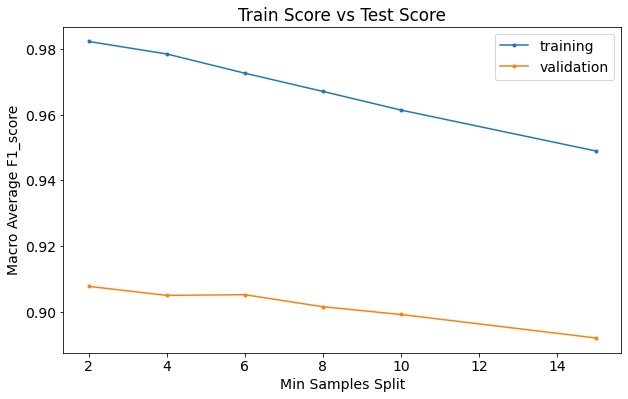

In [657]:
#plot the f1 socres 
plt.plot(params['min_samples_split'], rs3.cv_results_['mean_train_score'],marker='.', label = 'training')
plt.plot(params['min_samples_split'],rs3.cv_results_['mean_test_score'],marker='.',label = 'validation')
plt.legend()
plt.xlabel('Min Samples Split')
plt.ylabel('Macro Average F1_score')
plt.title('Train Score vs Test Score')
plt.show()

The validation f1_score remains stable from min_samples_split 2 to 6, and it starts to decreasing from 6 to the end with decreasing rate close to the decreasing rate of the training f1_score. This infornmation suggests that the variance is reducing from 2 to 6,so we can choose min_sample_split 6 to avoid overfitting and reduce the model complexity.

In [665]:
random_forest3 = RandomForestClassifier(n_estimators= 70,
                                        max_depth= 19,
                                        criterion= 'entropy',
                                        random_state = 42,
                                        max_features = 6, 
                                        min_samples_split = 6,
                                        n_jobs = -1)

#random_forest1.set_params(**rs1.best_params_)
random_forest3.fit(X_train,y_train)
pred_y_train = random_forest3.predict(X_train)
pred_y_val = random_forest3.predict(X_val)

In [666]:
print(classification_report(y_train,pred_y_train))

              precision    recall  f1-score   support

           1       0.98      0.94      0.96    135578
           2       0.95      0.98      0.97    181312
           3       0.99      0.99      0.99     22882
           4       0.99      0.97      0.98      1759
           5       0.99      0.90      0.94      6075
           6       0.99      0.98      0.98     11115
           7       1.00      0.97      0.99     13126

    accuracy                           0.97    371847
   macro avg       0.98      0.96      0.97    371847
weighted avg       0.97      0.97      0.97    371847



In [667]:
print(classification_report(y_val,pred_y_val))


              precision    recall  f1-score   support

           1       0.94      0.90      0.92     33894
           2       0.92      0.96      0.94     45328
           3       0.93      0.96      0.94      5721
           4       0.90      0.84      0.87       439
           5       0.91      0.73      0.81      1519
           6       0.92      0.89      0.90      2779
           7       0.97      0.93      0.95      3282

    accuracy                           0.93     92962
   macro avg       0.93      0.89      0.91     92962
weighted avg       0.93      0.93      0.93     92962



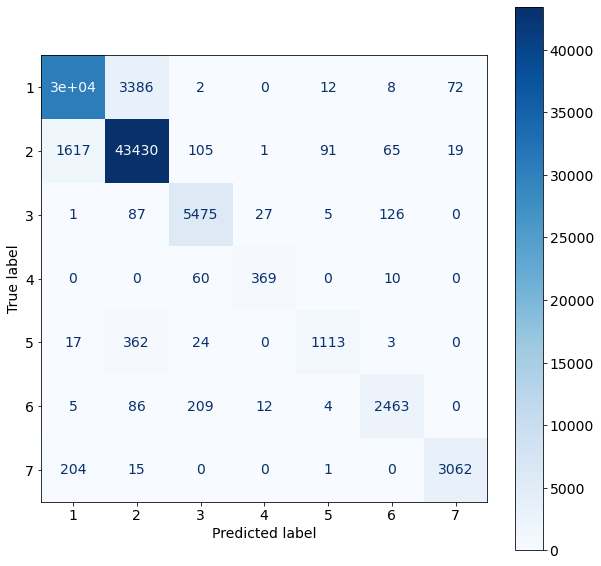

In [668]:
fig,ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(random_forest3,X_val,y_val,cmap=plt.cm.Blues,ax = ax)
plt.show()


The results of the validation set are almost equally good as the results of last model with min_sample_split 2.
This model also reduces the risk of overfitting on the training set, given a slightly lower training scores. 

## 4.5 Perform Oversampling On the Data

### 4.5.1 Perform Oversampling On the Training set

In order to address the issue of class imblance and improve the performance on the minorities, we implement oversampling and undersampling on the trainning set, and keep validation set and test set intact.

In [7]:
train.Cover_Type.value_counts()

2    181312
1    135578
3     22882
7     13126
6     11115
5      6075
4      1759
Name: Cover_Type, dtype: int64

In [8]:
#set the target counts for the undersampled classes
#covtype1_count = 50000
#covtype2_count = 50000
#covtype3_count = 8000

#set the target counts for the oversampled classe
covtype4_count = 3000
covtype5_count  = 10000


#perfrom oversampling on our training data
pipe = make_pipeline(
    BorderlineSMOTE(sampling_strategy={4:covtype4_count, 5: covtype5_count}),
    #NearMiss(sampling_strategy={1 :covtype1_count,2:covtype2_count})
    )

X_train_res, y_train_res = pipe.fit_resample(X_train, y_train)

In [15]:
#sampled size for each class
y_train_res.value_counts()

2    181312
1    135578
3     22882
7     13126
6     11115
5     10000
4      3000
Name: Cover_Type, dtype: int64

### 4.5.2 Train Our Best Decision Tree Model On the Resampled Training Data

In [11]:
#train our model on the resampled training data with our optimal hyperparamters
decision_tree_res = tree.DecisionTreeClassifier(criterion = 'entropy',max_depth= 19,random_state = 42)
decision_tree_res.fit(X_train_res,y_train_res)

pred_y_train = decision_tree_res.predict(X_train)
pred_y_val = decision_tree_res.predict(X_val)

In [12]:
print(classification_report(y_train,pred_y_train))

              precision    recall  f1-score   support

           1       0.95      0.94      0.95    135578
           2       0.95      0.96      0.96    181312
           3       0.99      0.99      0.99     22882
           4       1.00      0.99      0.99      1759
           5       0.93      0.97      0.95      6075
           6       0.98      0.98      0.98     11115
           7       0.99      0.98      0.99     13126

    accuracy                           0.96    371847
   macro avg       0.97      0.97      0.97    371847
weighted avg       0.96      0.96      0.96    371847



In [16]:
print(classification_report(y_val,pred_y_val))  

              precision    recall  f1-score   support

           1       0.91      0.89      0.90     33894
           2       0.92      0.93      0.92     45328
           3       0.92      0.93      0.92      5721
           4       0.83      0.82      0.82       439
           5       0.78      0.84      0.81      1519
           6       0.86      0.86      0.86      2779
           7       0.95      0.93      0.94      3282

    accuracy                           0.91     92962
   macro avg       0.88      0.89      0.88     92962
weighted avg       0.91      0.91      0.91     92962



Oversampleling technic does not help our decisioon tree model improve the ability to identify the minorities. The precision and recall of class 4 are reduced by 3% and 5% respectively. There aslo presents subtle decreases in scores of class 4 and 6.

### 4.5.3 Train Our Best Random Forest Model On the Resampled  Training Data

In [9]:
random_forestd_res = RandomForestClassifier(n_estimators= 70,
                                            max_depth= 19,
                                            criterion= 'entropy',
                                            random_state = 42,
                                            max_features = 6, 
                                            min_samples_split = 6,
                                            n_jobs = -1)

random_forestd_res.fit(X_train_res,y_train_res)
pred_y_train = random_forestd_res.predict(X_train)
pred_y_val = random_forestd_res.predict(X_val)

In [662]:
print(classification_report(y_train,pred_y_train))

              precision    recall  f1-score   support

           1       0.98      0.94      0.96    135578
           2       0.96      0.99      0.97    181312
           3       0.99      0.99      0.99     22882
           4       0.98      0.98      0.98      1759
           5       0.98      0.96      0.97      6075
           6       0.99      0.98      0.98     11115
           7       1.00      0.97      0.98     13126

    accuracy                           0.97    371847
   macro avg       0.98      0.97      0.98    371847
weighted avg       0.97      0.97      0.97    371847



In [663]:
print(classification_report(y_val,pred_y_val))

              precision    recall  f1-score   support

           1       0.95      0.90      0.92     33894
           2       0.92      0.96      0.94     45328
           3       0.94      0.95      0.94      5721
           4       0.87      0.89      0.88       439
           5       0.87      0.82      0.84      1519
           6       0.92      0.89      0.90      2779
           7       0.97      0.93      0.95      3282

    accuracy                           0.93     92962
   macro avg       0.92      0.90      0.91     92962
weighted avg       0.93      0.93      0.93     92962



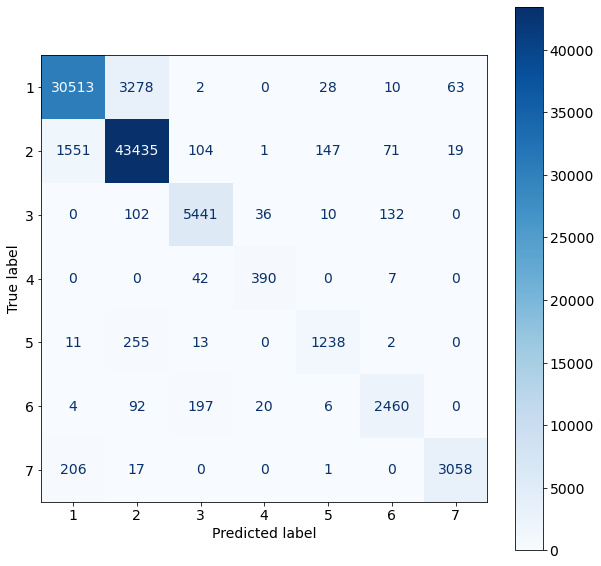

In [664]:
fig,ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(random_forestd_res,X_val,y_val,cmap=plt.cm.Blues,ax = ax)
plt.show()

Compared to the best random forest model without resampling, the recalls of class 4 and class 5 have growed by 5% and 9% respectively while the f1-scores growed by 1% and 3%. Meanwhile, the performence on other classes is very smilar. 
Both models have marco average f1-scores 0.91 and accurracy 0.93.

## 4.6 Final Model Selection

By far,we have 4 condidate models. Two decision tree models, one without resampling and one with resampling, the same is for random forest models. The two random forest models outperform the decision trees models across accuraccy, macro average f1-score, precision, and recall. Both of the random forest models have macro f1-score 0.91 and accuracy 0.93, which is 3% and 2% higher than those of the decison tree models. At last, the reason why I choose the random forest model with over resampling over the one without resampling is because it gives a better result on the macro recall, especially a much higher results on our minority classes 4 and 5. In other words, this model makes sure a higher raito of minorities can be effectively caught out from majorities. 


In [18]:
# Let's evaluate our final model
pred_y_test = random_forestd_res.predict(X_test)
print(classification_report(y_test,pred_y_test))

              precision    recall  f1-score   support

           1       0.95      0.90      0.92     42368
           2       0.92      0.96      0.94     56661
           3       0.93      0.95      0.94      7151
           4       0.88      0.88      0.88       549
           5       0.90      0.82      0.86      1899
           6       0.91      0.87      0.89      3473
           7       0.97      0.93      0.95      4102

    accuracy                           0.93    116203
   macro avg       0.92      0.90      0.91    116203
weighted avg       0.93      0.93      0.93    116203



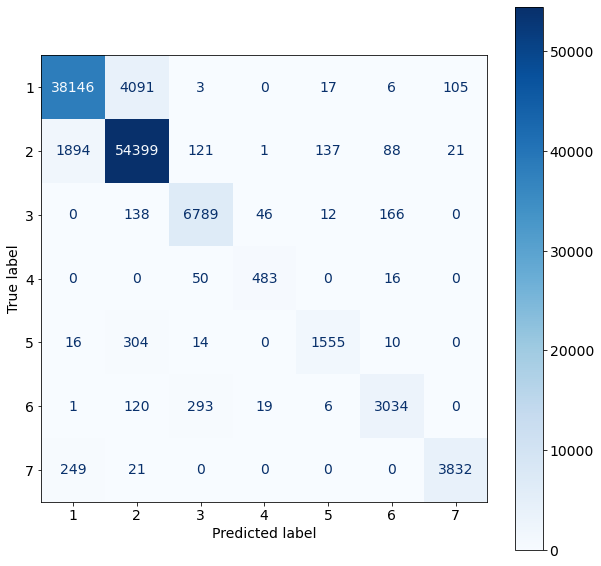

In [20]:
fig,ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(random_forestd_res,X_test,y_test,cmap=plt.cm.Blues,ax = ax)
plt.show()

The test socres are very statisfying, which is close to the one of the validation set even though the test sample size is much bigger. The the macro average f1-score and accuracy are still 0.91 and 0.93, same as the validation set. The performance on the minorities are very stable. There is a 1% percent decrease in recall of class 4 and the the one of class 5 remains unchanged. The performance on the majority classes are just as good as usual.